In [1]:
def mvmd(signal, alpha, tau, K, DC, init, tol, max_N):
    # ---------------------
    #  signal  - the time domain signal (1D) to be decomposed
    #  alpha   - the balancing parameter of the data-fidelity constraint
    #  tau     - time-step of the dual ascent ( pick 0 for noise-slack )
    #  K       - the number of modes to be recovered
    #  DC      - true if the first mode is put and kept at DC (0-freq)
    #  init    - 0 = all omegas start at 0
    #                     1 = all omegas start uniformly distributed
    #                     2 = all omegas initialized randomly
    #  tol     - tolerance of convergence criterion; typically around 1e-6
    #
    #  Output:
    #  -------
    #  u       - the collection of decomposed modes
    #  u_hat   - spectra of the modes
    #  omega   - estimated mode center-frequencies
    #

    # import numpy as np
    # import math
    # import matplotlib.pyplot as plt
    import torch

    # Period and sampling frequency of input signal
    C, T = signal.shape # T:length of signal C:  channel number
    fs = 1 / float(T)

    # extend the signal by mirroring
    # T = save_T
    # print(T)
    f_mirror = torch.zeros(C, 2*T)
    #print(f_mirror)
    f_mirror[:,0:T//2] = torch.flip(signal[:,0:T//2], dims=[-1]) 
    # print(f_mirror)
    f_mirror[:,T//2:3*T//2] = signal
    # print(f_mirror)
    f_mirror[:,3*T//2:2*T] = torch.flip(signal[:,T//2:], dims=[-1])
    # print(f_mirror)
    f = f_mirror


    # Time Domain 0 to T (of mirrored signal)
    T = float(f.shape[1])
    # print(T)
    t = torch.linspace(1/float(T), 1, int(T))
    # print(t)

    # Spectral Domain discretization
    freqs = t - 0.5 - 1/T

    # Maximum number of iterations (if not converged yet, then it won't anyway)
    N = max_N

    # For future generalizations: individual alpha for each mode
    Alpha = alpha * torch.ones(K, dtype=torch.cfloat)

    # Construct and center f_hat
    f_hat = torch.fft.fftshift(torch.fft.fft(f))
    f_hat_plus = f_hat
    f_hat_plus[:, 0:int(int(T)/2)] = 0

    # matrix keeping track of every iterant // could be discarded for mem
    u_hat_plus = torch.zeros((N, len(freqs), K, C), dtype=torch.cfloat)

    # Initialization of omega_k
    omega_plus = torch.zeros((N, K), dtype=torch.cfloat)
                        
    if (init == 1):
        for i in range(1, K+1):
            omega_plus[0,i-1] = (0.5/K)*(i-1)
    elif (init==2):
        omega_plus[0,:] = torch.sort(torch.exp(torch.log(fs)) +
        (torch.log(0.5) - torch.log(fs)) * torch.random.rand(1, K))
    else:
        omega_plus[0,:] = 0

    if (DC):
        omega_plus[0,0] = 0


    # start with empty dual variables
    lamda_hat = torch.zeros((N, len(freqs), C), dtype=torch.cfloat)

    # other inits
    uDiff = tol+2.2204e-16 #updata step
    n = 1 #loop counter
    sum_uk = torch.zeros((len(freqs), C)) #accumulator

    T = int(T)

    # ----------- Main loop for iterative updates

    while uDiff > tol and n < N:
        # update first mode accumulator
        k = 1
        sum_uk = u_hat_plus[n-1,:,K-1,:] + sum_uk - u_hat_plus[n-1,:,0,:]

        #update spectrum of first mode through Wiener filter of residuals
        for c in range(C):
            u_hat_plus[n,:,k-1,c] = (f_hat_plus[c,:] - sum_uk[:,c] - 
            lamda_hat[n-1,:,c]/2) \
        / (1 + Alpha[k-1] * torch.square(freqs - omega_plus[n-1,k-1]))
   
        #update first omega if not held at 0
        if DC == False:
            omega_plus[n,k-1] = torch.sum(torch.mm(freqs[T//2:T].unsqueeze(0), 
                            torch.square(torch.abs(u_hat_plus[n,T//2:T,k-1,:])))) \
            / torch.sum(torch.square(torch.abs(u_hat_plus[n,T//2:T,k-1,:])))


        for k in range(2, K+1):

            #accumulator
            sum_uk = u_hat_plus[n,:,k-2,:] + sum_uk - u_hat_plus[n-1,:,k-1,:]

            #mode spectrum
            for c in range(C):
                u_hat_plus[n,:,k-1,c] = (f_hat_plus[c,:] - sum_uk[:,c] - 
            lamda_hat[n-1,:,c]/2) \
            / (1 + Alpha[k-1] * torch.square(freqs-omega_plus[n-1,k-1]))
    #         print('u_hat_plus'+str(k))
    #         print(u_hat_plus[n,:,k-1])
            
            #center frequencies
            omega_plus[n,k-1] = torch.sum(torch.mm(freqs[T//2:T].unsqueeze(0),
                torch.square(torch.abs(u_hat_plus[n,T//2:T,k-1,:])))) \
                /  torch.sum(torch.square(torch.abs(u_hat_plus[n,T//2:T:,k-1,:])))

        #Dual ascent
    #     print(u_hat_plus.shape) tau一般是0，这里不用管
        lamda_hat[n,:,:] = lamda_hat[n-1,:,:] # + tau * (torch.sum(u_hat_plus[n,:,:,:], dim=1)
                       #  - f_hat_plus)
    #     print('lamda_hat'+str(n))
    #     print(lamda_hat[n,:])

        #loop counter
        n = n + 1

        #converged yet?
        uDiff = 2.2204e-16

        for i in range(1, K+1):
            uDiff=uDiff+1 / float(T) * torch.mm(u_hat_plus[n-1,:,i-1,:] - u_hat_plus[n-2,:,i-1,:], 
                                                ((u_hat_plus[n-1,:,i-1,:]-u_hat_plus[n-2,:,i-1,:]).conj()).conj().T)
            
        uDiff = torch.sum(torch.abs(uDiff))

        
    # ------ Postprocessing and cleanup

    # discard empty space if converged early

    N = min(N, n)
    omega = omega_plus[0:N,:]

    # Signal reconstruction
    u_hat = torch.zeros((T,K,C), dtype=torch.cfloat)
    for c in range(C):
        u_hat[T//2:T,:,c] = torch.squeeze(u_hat_plus[N-1,T//2:T,:,c])
        # print('u_hat')
        # print(u_hat.shape)
        # print(u_hat)
        second_index = list(range(1,T//2+1))
        second_index.reverse()
        u_hat[second_index,:,c] = torch.squeeze(torch.conj(u_hat_plus[N-1,T//2:T,:,c]))
        u_hat[0,:,c] = torch.conj(u_hat[-1,:,c])
    # print('u_hat')
    # print(u_hat)
    u = torch.zeros((K,len(t),C), dtype=torch.cfloat)

    for k in range(1, K+1):
        for c in range(C):
            u[k-1,:,c]  = (torch.fft.ifft(torch.fft.ifftshift(u_hat[:,k-1,c]))).real


    # remove mirror part 
    u = u[:,T//4:3*T//4,:]

    # print(u_hat.shape)
    #recompute spectrum
    u_hat = torch.zeros((T//2,K,C), dtype=torch.cfloat)

    for k in range(1, K+1):
        for c in range(C):
            u_hat[:,k-1,c] = torch.fft.fftshift(torch.fft.fft(u[k-1,:,c])).conj()
    
    # ifftshift 
    u = torch.fft.ifftshift(u, dim=-1)
            
    
        
    return (u.real, u_hat, omega)

In [ ]:
import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt

def load_data(file_path, device):
    """
    从CSV文件中加载数据，并转换为PyTorch张量。

    参数：
    file_path: str - CSV文件的路径。
    device: torch.device - 设备（CPU或GPU）。

    返回：
    signal: torch.Tensor - 多变量时间序列数据的张量。
    """
    # 读取CSV文件
    df = pd.read_csv(file_path)

    # 确保列名为'SWH', 'ZUWP', 'PEWP', 'MWH'
    columns = ['SWH', 'ZUWP', 'PEWP', 'MWH']
    df = df[columns]

    # 将DataFrame转换为PyTorch张量，并移动到指定设备
    signal = torch.tensor(df.values.T, dtype=torch.float32).to(device)

    return signal

def mvmdGpu(signal, alpha, tau, K, DC, init, tol, max_N, device):
    """
    MVMD算法实现

    参数：
    signal - 输入的多变量信号
    alpha - 定义提取模态带宽的参数
    tau - 对偶上升的时间步长
    K - 需要恢复的模态数量
    DC - 如果第一个模态保持在直流（0频率），则为True
    init - 初始化模式（0=所有omega从0开始，1=均匀分布，2=随机初始化）
    tol - ADMM收敛的容差值
    max_N - 最大迭代次数
    device - 设备（CPU或GPU）

    返回：
    u - 分解的模态集合
    u_hat - 模态的频谱
    omega - 估计的模态中心频率
    """
    # 获取信号的周期和采样频率
    C, T = signal.shape  # T: 信号长度, C: 通道数量
    fs = 1 / float(T)

    # 通过镜像扩展信号
    f_mirror = torch.zeros(C, 2*T, device=device)
    f_mirror[:, 0:T//2] = torch.flip(signal[:, 0:T//2], dims=[-1])
    f_mirror[:, T//2:3*T//2] = signal
    f_mirror[:, 3*T//2:2*T] = torch.flip(signal[:, T//2:], dims=[-1])
    f = f_mirror

    # 时间域离散化
    T = float(f.shape[1])
    t = torch.linspace(1/float(T), 1, int(T), device=device)

    # 频谱域离散化
    freqs = t - 0.5 - 1/T

    # 最大迭代次数
    N = max_N

    # 为每个模态初始化alpha
    Alpha = alpha * torch.ones(K, dtype=torch.cfloat, device=device)

    # 构建并中心化f_hat
    f_hat = torch.fft.fftshift(torch.fft.fft(f))
    f_hat_plus = f_hat.clone()
    f_hat_plus[:, 0:int(T/2)] = 0

    # 初始化u_hat_plus和omega_plus
    u_hat_plus = torch.zeros((N, len(freqs), K, C), dtype=torch.cfloat, device=device)
    omega_plus = torch.zeros((N, K), dtype=torch.cfloat, device=device)

    # 初始化omega_k
    if init == 1:
        for i in range(1, K+1):
            omega_plus[0, i-1] = (0.5/K) * (i-1)
    elif init == 2:
        omega_plus[0, :] = torch.sort(torch.exp(torch.log(fs)) +
                                      (torch.log(0.5) - torch.log(fs)) * torch.rand(1, K, device=device))
    else:
        omega_plus[0, :] = 0

    if DC:
        omega_plus[0, 0] = 0

    # 初始化拉格朗日乘子
    lamda_hat = torch.zeros((N, len(freqs), C), dtype=torch.cfloat, device=device)

    # 其他初始化
    uDiff = tol + 2.2204e-16  # 更新步长
    n = 1  # 循环计数器
    sum_uk = torch.zeros((len(freqs), C), device=device)  # 累加器

    T = int(T)

    # ----------- 迭代更新的主循环

    while uDiff > tol and n < N:
        # 更新第一个模态的累加器
        k = 1
        sum_uk = u_hat_plus[n-1, :, K-1, :] + sum_uk - u_hat_plus[n-1, :, 0, :]

        # 通过残差的维纳滤波器更新第一个模态的频谱
        for c in range(C):
            u_hat_plus[n, :, k-1, c] = (f_hat_plus[c, :] - sum_uk[:, c] -
                                        lamda_hat[n-1, :, c]/2) \
                / (1 + Alpha[k-1] * torch.square(freqs - omega_plus[n-1, k-1]))

        # 如果第一个模态不保持在0频率，更新第一个omega
        if not DC:
            omega_plus[n, k-1] = torch.sum(torch.mm(freqs[T//2:T].unsqueeze(0),
                                                    torch.square(torch.abs(u_hat_plus[n, T//2:T, k-1, :])))) \
                / torch.sum(torch.square(torch.abs(u_hat_plus[n, T//2:T, k-1, :])))

        for k in range(2, K+1):
            # 累加器
            sum_uk = u_hat_plus[n, :, k-2, :] + sum_uk - u_hat_plus[n-1, :, k-1, :]

            # 模态频谱
            for c in range(C):
                u_hat_plus[n, :, k-1, c] = (f_hat_plus[c, :] - sum_uk[:, c] -
                                            lamda_hat[n-1, :, c]/2) \
                    / (1 + Alpha[k-1] * torch.square(freqs - omega_plus[n-1, k-1]))

            # 中心频率
            omega_plus[n, k-1] = torch.sum(torch.mm(freqs[T//2:T].unsqueeze(0),
                                                    torch.square(torch.abs(u_hat_plus[n, T//2:T, k-1, :])))) \
                / torch.sum(torch.square(torch.abs(u_hat_plus[n, T//2:T, k-1, :])))

        # 对偶上升
        lamda_hat[n, :, :] = lamda_hat[n-1, :, :]

        # 循环计数器
        n += 1

        # 是否收敛
        uDiff = 2.2204e-16
        for i in range(1, K+1):
            uDiff += 1 / float(T) * torch.mm(u_hat_plus[n-1, :, i-1, :] - u_hat_plus[n-2, :, i-1, :],
                                             ((u_hat_plus[n-1, :, i-1, :] - u_hat_plus[n-2, :, i-1, :]).conj()).conj().T)
        uDiff = torch.sum(torch.abs(uDiff))

    # ------ 后处理和清理

    # 如果提前收敛，丢弃空白空间
    N = min(N, n)
    omega = omega_plus[0:N, :]

    # 信号重构
    u_hat = torch.zeros((T, K, C), dtype=torch.cfloat, device=device)
    for c in range(C):
        u_hat[T//2:T, :, c] = torch.squeeze(u_hat_plus[N-1, T//2:T, :, c])
        second_index = list(range(1, T//2+1))
        second_index.reverse()
        u_hat[second_index, :, c] = torch.squeeze(torch.conj(u_hat_plus[N-1, T//2:T, :, c]))
        u_hat[0, :, c] = torch.conj(u_hat[-1, :, c])

    u = torch.zeros((K, len(t), C), dtype=torch.cfloat, device=device)
    for k in range(1, K+1):
        for c in range(C):
            u[k-1, :, c] = (torch.fft.ifft(torch.fft.ifftshift(u_hat[:, k-1, c]))).real

    # 移除镜像部分
    u = u[:, T//4:3*T//4, :]

    # 重新计算频谱
    u_hat = torch.zeros((T//2, K, C), dtype=torch.cfloat, device=device)
    for k in range(1, K+1):
        for c in range(C):
            u_hat[:, k-1, c] = torch.fft.fftshift(torch.fft.fft(u[k-1, :,

In [ ]:

import numpy as np


def SMVMD(signal, alphaMin, alphaMax, beta, init, tau, eps1, eps2, K):
    # Successive Multivariate Variational Mode Decomposition
    # Input and Parameters:
    # ---------------------
    # signal    - input multivariate signal that needs to be decomposed
    # alphaMin  - the min parameter that defines the bandwidth of extracted modes
    # alphaMax  - the max parameter that defines the bandwidth of extracted modes
    #             (low value of alpha yields higher bandwidth)
    # beta      - the change rate of alpha > 1
    # init      - 0 = the first omega start at 0
    #           - 1 = the first omega initialized randomly
    # tau       - time-step of the dual ascent ( pick 0 for noise-slack )
    # eps1      - tolerance value for convergence of ADMM
    # eps2      - tolerance value for convergence of ternimation
    # K        - the maximum of mode number
    #
    #
    # Output:
    # ----------------------
    # u       - the collection of decomposed modes
    # u_hat   - spectra of the modes
    # omega   - estimated mode center-frequencies

    ## Check for getting number of channels from input signal
    row, col = signal.shape
    if row > col:
        C = col  # number of channels
        T = row  # length of the Signal
        signal = signal.T
    else:
        C = row  # number of channels
        T = col  # length of the Signal

    ## ---------- Preparations
    # Mirroring
    flag = False
    f = np.zeros((C, 2 * T))
    if T % 2 == 0:
        flag = True
        f[:, :T // 2] = -signal[:, T // 2 - 1 ::-1]
        f[:, T // 2:T // 2 + T] = signal
        f[:, T // 2 + T:2 * T] = -signal[:, T - 1:T // 2 - 1:-1]
    else:
        f[:, :(T - 1) // 2] = -signal[:, T // 2 - 1 ::-1]
        f[:, (T + 1) // 2:(T + 1) // 2 + T] = signal
        f[:, (T + 1) // 2 + T:2 * T] = -signal[:, T:T // 2:- 1]

    # Time Domain 0 to T (of mirrored signal)
    T = f.shape[1]
    t = np.arange(1, T + 1) / T

    # frequency points
    fp = t - 0.5 - 1 / T
    fp = np.asarray(fp[T // 2:])

    # Construct and center f_hat
    f_hat = np.fft.fftshift(np.fft.fft(f, axis=1), axes=1)
    f_hat_plus = f_hat[:, T // 2:]

    ## ------------ 外部初始化
    u_hat_plus = np.zeros((K, T // 2, C), dtype=np.complex128)  # 存储模式的频域结果
    omega = np.zeros(K)  # 中心频率存储
    omega_iter = [[] for _ in range(K)]  # 中心频率迭代历程存储
    k = 0  # 模式个数
    sum_uk = 0  # 前k-1个模式和
    sum_fuk = 0  # 前k-1个滤波因子和
    eps = np.finfo(np.float64).eps
    tol2 = eps2 + eps  # 算法终止阈值

    ## ----------- 执行算法求解
    while tol2 > eps2 and k < K:
        k += 1  # 模式数加一

        ## -----------模式k提取初始化参数设置
        if init == 0:
            omega[k - 1] = 0.25  # 归一化频率中点初始化
        else:
            omega[k - 1] = np.random.rand() / 2.56  # 随机初始化

        omega_iter[k - 1].append(omega[k - 1])  # 记录k个模式中心频率初始值
        alpha = alphaMin  # 初始带宽控制参数alpha
        lambda_hat = np.zeros((C, T // 2))  # 初始化拉格朗日乘子
        tol1 = eps1 + eps  # 模式k更新终止阈值
        n = 1  # 初始化迭代计数器
        uk_hat_c = np.zeros((C, T // 2), dtype=np.complex128)  # 初始化当前模式频域结果
        uk_hat_n = np.zeros((C, T // 2), dtype=np.complex128)  # 初始化下一个模式频域结果
        filt_uk = alpha * (fp - omega[k - 1]) ** 2  # 初始化第k个模式滤波器

        ## ----------- 迭代更新提取第k个模式
        while tol1 > eps1 and n < 100:
            # 更新第k个多变量模式
            for c in range(C):
                uk_hat_n[c, :] = (f_hat_plus[c, :] + (filt_uk ** 2) * uk_hat_c[c, :] + lambda_hat[c, :] / 2) / (
                        (1 + (filt_uk ** 2)) * (1 + 2 * filt_uk + sum_fuk)
                )

            # 更新中心频率
            numerator = np.sum((np.abs(uk_hat_n.T) ** 2)*np.asarray(fp).reshape(-1, 1))
            denominator = np.sum(np.abs(uk_hat_n.flatten()) ** 2)
            omega[k - 1] = numerator / denominator

            filt_uk = alpha * (fp - omega[k - 1]) ** 2

            # Dual ascent
            lambda_hat = lambda_hat + tau * (
                    (f_hat_plus - uk_hat_n + lambda_hat / 2) / (1 + filt_uk ** 2) - lambda_hat / 2
            )

            # converged yet?
            tol1 = np.sum(np.abs(uk_hat_n - uk_hat_c) ** 2) / (np.sum(np.abs(uk_hat_c) ** 2) + eps)
            uk_hat_c = uk_hat_n

            alpha = min(alpha * beta, alphaMax)

            n += 1  # 循环计数器加一
            omega_iter[k - 1].append(omega[k - 1])  # 记录k个模式中心频率迭代历程

        sum_uk = sum_uk + uk_hat_c
        sum_fuk = sum_fuk + 1 / (filt_uk ** 2)
        u_hat_plus[k - 1, :, :] = uk_hat_c.T

        # converged yet?
        tol2 = np.sum(np.abs(f_hat_plus - sum_uk) ** 2) / np.sum(np.abs(f_hat_plus) ** 2)

    ## ------ Post-processing and cleanup
    # discard the last item, which maybe a noise item
    K = k
    omega = omega[:K]
    omega_iter = omega_iter[:K]
    u_hat_plus = u_hat_plus[:K, :, :]

    # Signal reconstruction
    u_hat = np.zeros((K, T, C), dtype=np.complex128)
    u_hat[:, T // 2:, :] = u_hat_plus
    u_hat[:, T // 2:0:-1, :] = np.conj(u_hat_plus)
    u_hat[:, 0, :] = np.conj(u_hat[:, -1, :])

    u = np.zeros((K, T, C))
    for k in range(K):
        for c in range(C):
            u[k, :, c] = np.real(np.fft.ifft(np.fft.ifftshift(u_hat[k, :, c])))

    # remove mirror part
    if flag:
        u = u[:, T // 4:3 * T // 4, :]
    else:
        x = u[:, (T + 2) // 4:(3 * T + 2) // 4, :]
        u = u[:, (T + 2) // 4:(3 * T + 2) // 4, :]

    # recompute spectrum
    u_hat = np.zeros((K, np.max(signal.shape), C), dtype=np.complex128)
    for k in range(K):
        for c in range(C):
            u_hat[k, :, c] = np.fft.fftshift(np.fft.fft(u[k, :, c]))

    return u, u_hat, omega_iter


# if __name__ == '__main__':
#     import matplotlib.pyplot as plt
#     from scipy.io import loadmat
# 
#     fn = '../data.mat'
#     semg = loadmat(fn)['data']
#     # print(semg.keys())
# 
#     data = semg[10, :, :]
# 
#     del semg
# 
#     print(data.shape)
#     u, _, _ = SMVMD(
#         signal=data,
#         K=5,
#         tau=0,
#         alphaMin=10,
#         alphaMax=10000,
#         beta=1.5,
#         eps1=1e-6,
#         eps2=1e-6,
#         init=0
#     )
#     print(u.shape)
#     # a = np.random.rand(10).reshape(2, 5)
#     # print(a)
#     # b = a[:, 3::-1]
#     # print(b)
#     fig, ax = plt.subplots(10, 1, figsize=(10, 12))
#     for i in range(10):
#         ax[i].plot(data[:, i])
#         ax[i].plot(np.sum(u[:, :, i], axis=0))
# 
#     plt.show()

In [2]:
import pandas as pd
import torch

def load_data(file_path):
    """
    从CSV文件中加载数据，并转换为PyTorch张量。

    参数：
    file_path: str - CSV文件的路径。

    返回：
    signal: torch.Tensor - 多变量时间序列数据的张量。
    """
    # 读取CSV文件
    df = pd.read_csv(file_path)

    # 确保列名为'SWH', 'ZUWP', 'PEWP', 'MWH'
    columns = ['SWH', 'ZUWP', 'PEWP', 'MWH']
    df = df[columns]

    # 将DataFrame转换为PyTorch张量
    signal = torch.tensor(df.values.T, dtype=torch.float32)

    return signal

分解的模态： tensor([[[ 1.3701e+00,  5.1935e+00,  8.9289e+00,  2.3421e+00],
         [ 1.3699e+00,  5.1953e+00,  8.9161e+00,  2.3408e+00],
         [ 1.3695e+00,  5.1974e+00,  8.8929e+00,  2.3411e+00],
         ...,
         [ 1.9226e+00,  7.8300e+00,  1.0981e+01,  3.1883e+00],
         [ 1.9209e+00,  7.8271e+00,  1.0978e+01,  3.1817e+00],
         [ 1.9194e+00,  7.8253e+00,  1.0978e+01,  3.1782e+00]],

        [[-1.7435e-01, -5.7455e-01, -3.2072e+00, -2.0739e-01],
         [-1.7321e-01, -5.6849e-01, -3.2083e+00, -2.0653e-01],
         [-1.7097e-01, -5.5817e-01, -3.2066e+00, -2.0179e-01],
         ...,
         [ 2.2785e-01,  1.2813e+00,  1.3386e+00,  2.3667e-01],
         [ 2.2812e-01,  1.2873e+00,  1.3425e+00,  2.2858e-01],
         [ 2.2752e-01,  1.2898e+00,  1.3465e+00,  2.2414e-01]],

        [[-6.7722e-03, -1.8370e-02,  7.3326e-01, -5.9938e-02],
         [-1.1126e-02, -1.3436e-02,  7.0494e-01, -6.9543e-02],
         [-1.8923e-02, -6.7108e-03,  6.5530e-01, -8.2775e-02],
         ...,
  

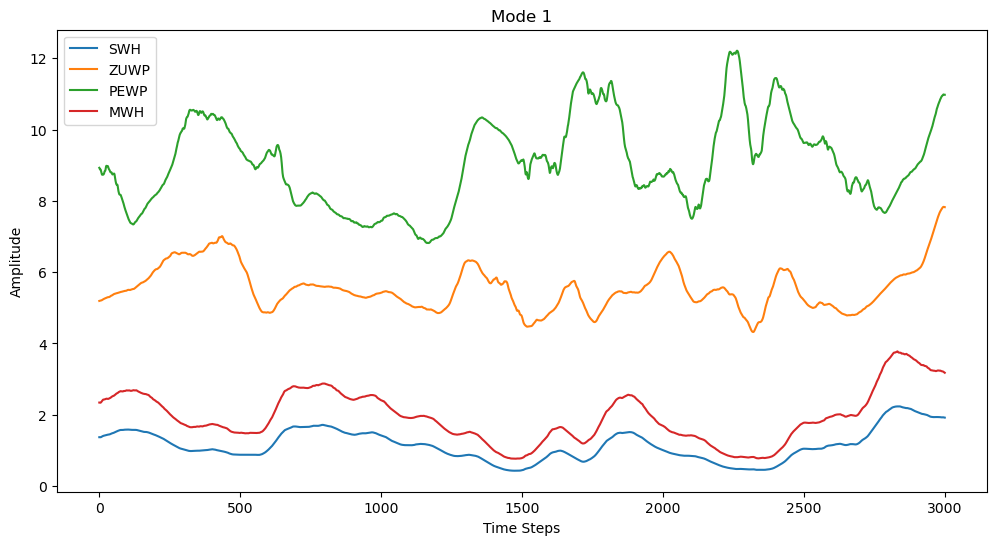

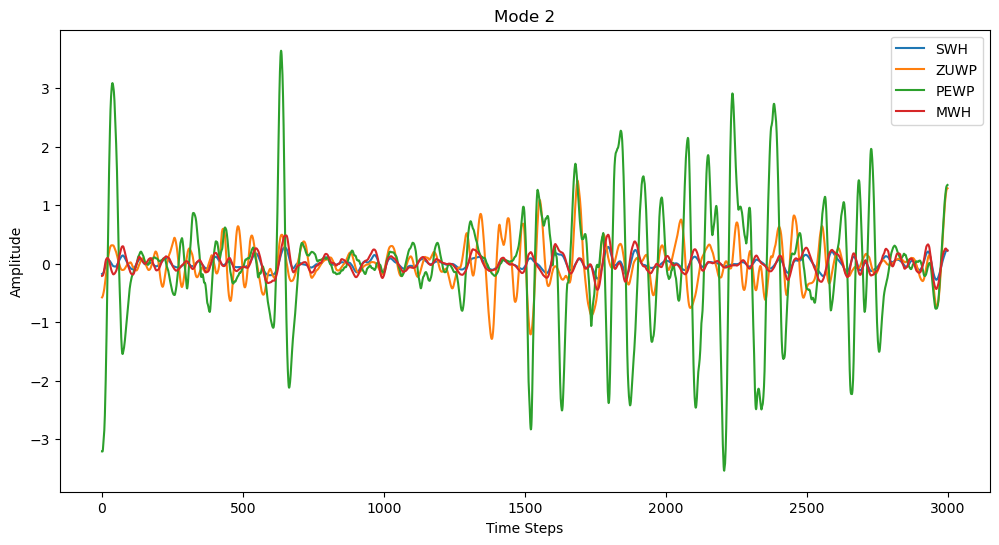

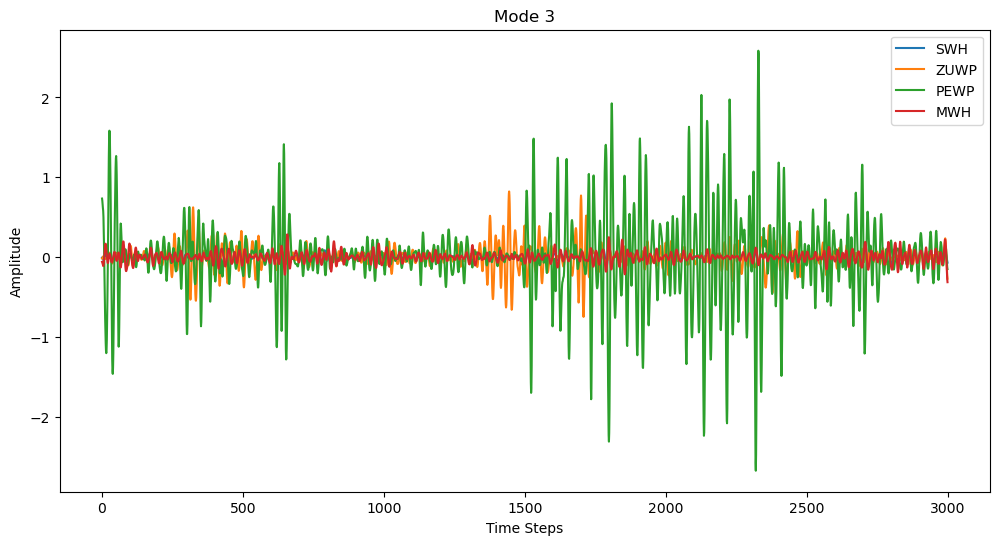

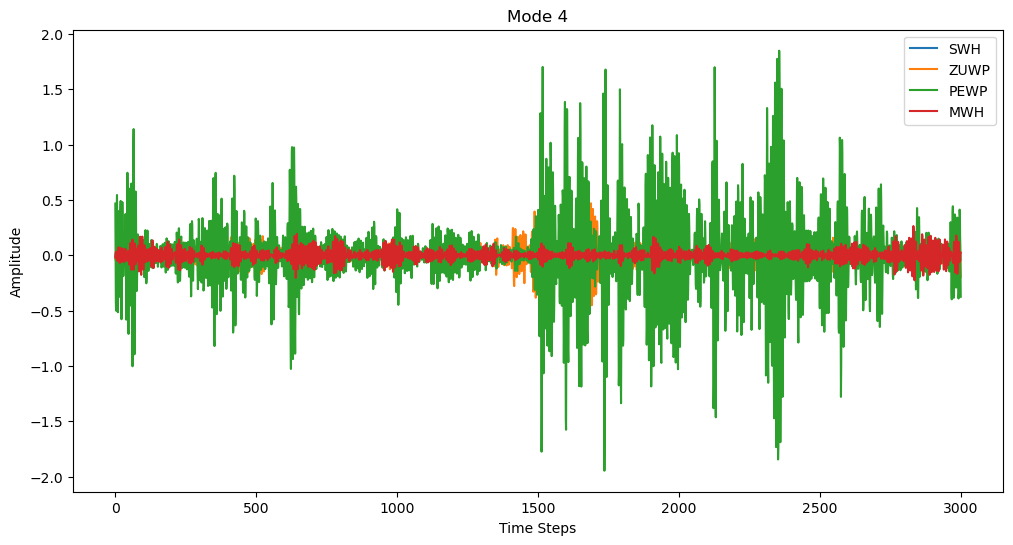

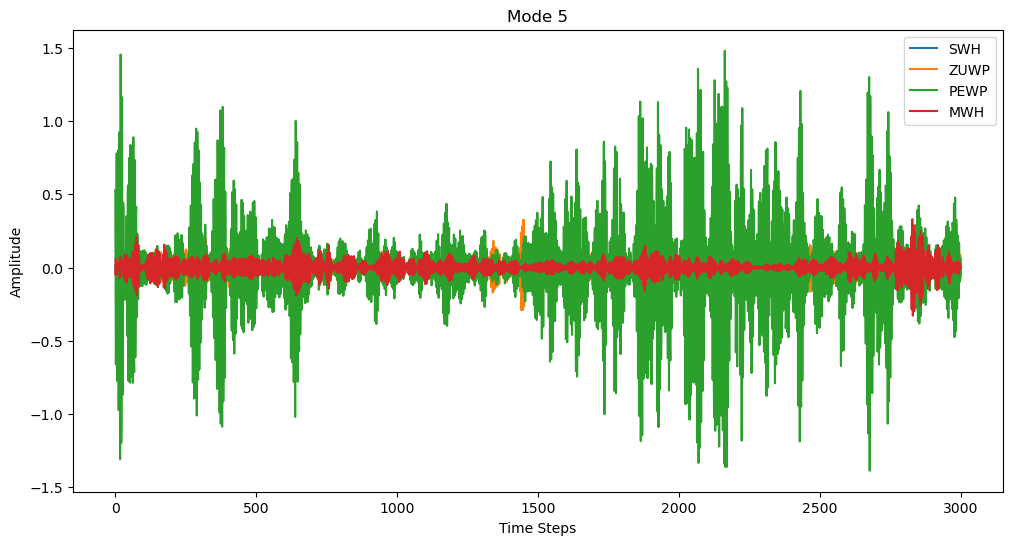

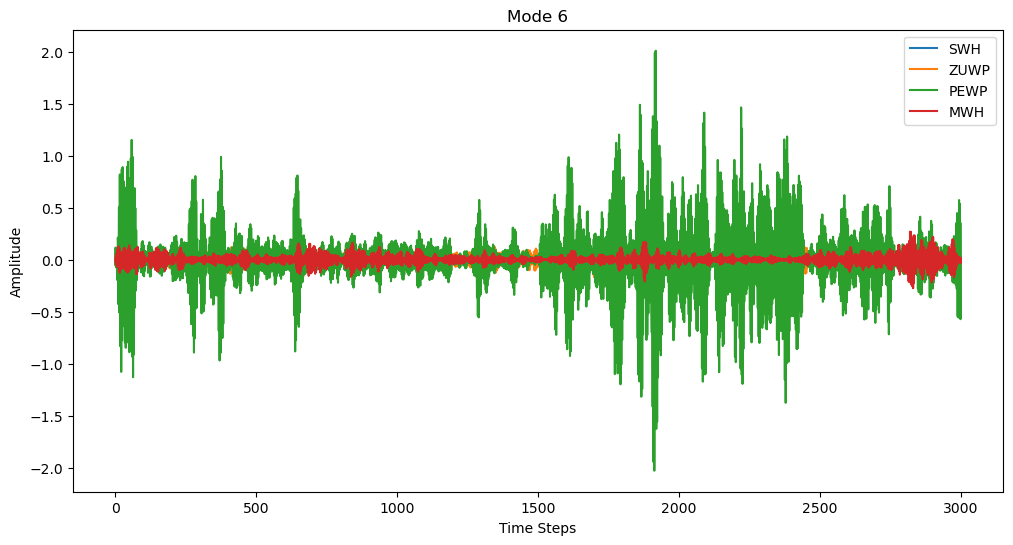

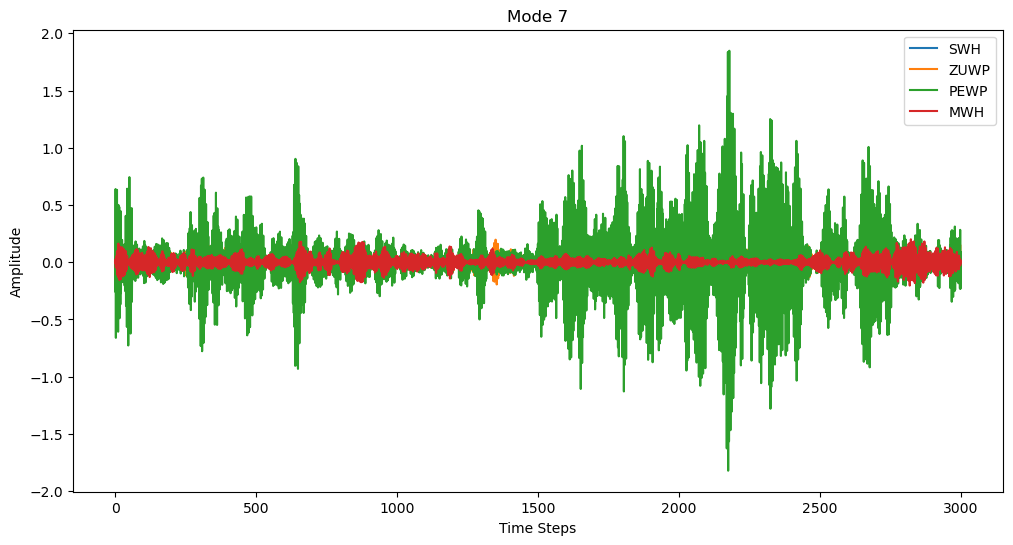

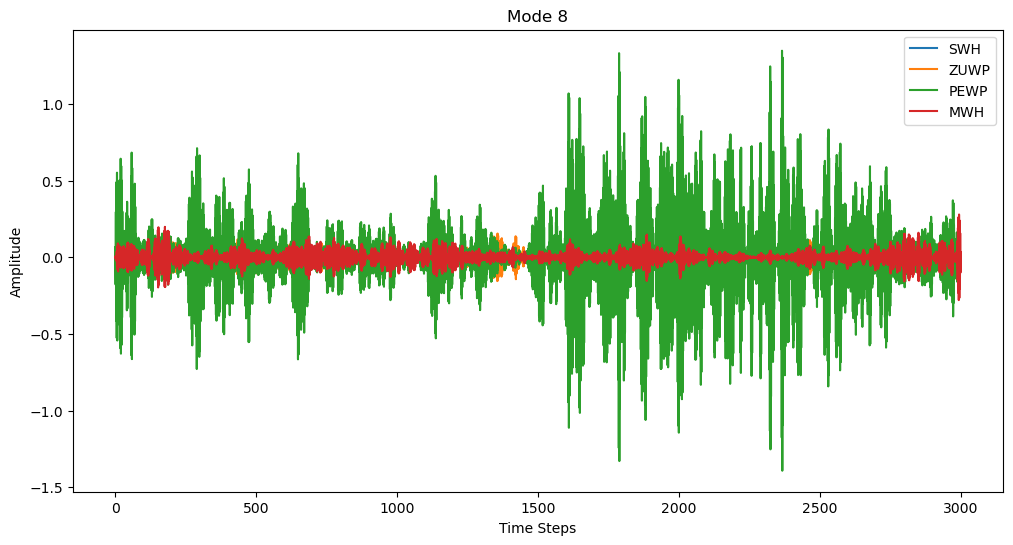

In [4]:
import matplotlib.pyplot as plt
def main(file_path):
    """
    主函数，加载数据并进行MVMD分解。

    参数：
    file_path: str - CSV文件的路径。
    """
    # 加载数据
    signal = load_data(file_path)

    # 调用MVMD函数
    u, u_hat, omega = mvmd(signal, alpha=2000, tau=0, K=8, DC=True, init=1, tol=1e-6, max_N=500)

    # 打印结果
    print("分解的模态：", u)
    print("模态的频谱：", u_hat)
    print("模态中心频率：", omega)

    # 绘制每个模态的时间序列
    num_modes = u.shape[0]
    time_steps = u.shape[1]
    channels = ['SWH', 'ZUWP', 'PEWP', 'MWH']

    for mode in range(num_modes):
        plt.figure(figsize=(12, 6))
        for channel in range(len(channels)):
            plt.plot(range(time_steps), u[mode, :, channel], label=channels[channel])
        plt.xlabel('Time Steps')
        plt.ylabel('Amplitude')
        plt.title(f'Mode {mode + 1}')
        plt.legend()
        plt.show()

# 调用主函数
main('E:/Dataset/waves/dataset1.csv')